In [1]:
!pip install emoji

!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.1 MB/s eta 0:00:00


# Módulos

In [2]:
# Módulos para tratamiento de Datos
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

# Módulos para Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    style="whitegrid",   # fondo claro con líneas suaves
    rc={
        'axes.edgecolor': '0.2',   # bordes más suaves
        'grid.color': '0.85',      # grid gris clarito
        'axes.labelcolor': '0.1',
        'text.color': '0.1',
        'xtick.color': '0.2',
        'ytick.color': '0.2'
    }
)
sns.set_palette("Greys_r")
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud

# sklearn,modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# módulos para tratamiento de texto
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

#modulos específicos
import emoji #para desmojizar
from gensim.models import Word2Vec

# modulos para la red recurrente
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Funciones

In [3]:

stop_words = set(stopwords.words('english'))

def plot_confusion_matrix(model, X_test, y_test):


    y_pred = model.predict(X_test)


    y_true = np.argmax(np.array(y_test), axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)


    cm = confusion_matrix(y_true, y_pred_labels)

    class_names = ["negativo", "neutral", "positivo"]


    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm,
        cmap=plt.cm.Blues,
        annot=True,
        fmt='d',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title('Confusion Matrix - LSTM', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.show()


def convert_emojis(text):
    # Cada emoji se convierte en: " EMOJI_nombre_del_emoji "
    return emoji.demojize(
        text,
        language="en",
        delimiters=(" EMOJI_", " ")
    )

def clean_text(text):
    # 0. Convertir emojis primero
    text = convert_emojis(text)  # usa la función de arriba

    # 1. Minúsculas
    text = text.lower()

    # 2. Quitar menciones
    text = re.sub(r'@\w+', ' ', text)

    # 3. Quitar URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # 4. Quitar puntos suspensivos y comillas raras
    text = text.replace('…', ' ')
    text = text.replace('“', ' ')
    text = text.replace('”', ' ')
    text = text.replace('’', ' ')

    # 5. Quitar números
    text = re.sub(r'\d+', ' ', text)

    # 6. Quitar signos de puntuación, pero dejando guiones bajos
    #    (porque nuestros tokens tienen "_")
    punct = string.punctuation.replace("_", "")
    text = text.translate(str.maketrans({p: " " for p in punct}))

    # 7. Quitar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()

    # 8. quitar stopwords pero conservando emojis
    tokens = text.split()
    cleaned_tokens = []
    for tok in tokens:
        # si es emoji_..., lo dejamos tal cual
        if tok.startswith("emoji_"):
            cleaned_tokens.append(tok)
            continue

        # quitar stopwords
        if tok in stop_words:
            continue

        # lematizar palabra normal
        lemma = lemmatizer.lemmatize(tok)   # por defecto asume sustantivo
        cleaned_tokens.append(lemma)

    return " ".join(cleaned_tokens)

max_words = 10000
max_len = 50

def tokenize_pad_sequences(text):
    '''
    Esta función aplica tokenización y padding
    '''
    # Tokenizacion
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)

    X = tokenizer.texts_to_sequences(text)
    # hacemos padding
    X = pad_sequences(X, padding='post', maxlen=max_len)

    return X, tokenizer

def tokenize_valid_set(texts, tokenizer, max_len = max_len):
    seq = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    return padded

etiquetas = {'negative' : 0, 'neutral': 1, 'positive':2}

# --- Función para crear un WordCloud ---
def create_wc(text):
    return WordCloud(
        width=900,
        height=450,
        background_color="white",
        colormap="Greys",
        max_words=120
    ).generate(text)

# Carga de Datos

In [4]:
df = pd.read_csv('/content/Tweets.csv')

In [5]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [6]:
cols = ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'airline', 'text', 'tweet_created', 'negativereason']
df = df[cols]

# Tratamiento

In [7]:
# Ejemplo para ver como limpia un tweet que trae un emoji
mask_emoji = df['text'].astype(str).str.contains("😅", na=False)
df_with_emoji = df[mask_emoji]

In [8]:
df_with_emoji['text'].values[0]

"@SouthwestAir 😅 you won't let me change my reservation online so now I'm just wasting my time. http://t.co/mHA3xXaeD5"

In [9]:
clean_text(df_with_emoji['text'].iloc[0])

'emoji_grinning_face_with_sweat let change reservation online wasting time'

In [10]:
#limpiamos_todo
df['final_text'] = df['text'].apply(clean_text)

In [11]:
# extraemos la fecha
df['tweet_created'] = pd.to_datetime(df['tweet_created'], format='%Y-%m-%d %H:%M:%S %z')
df['date'] = df['tweet_created'].dt.date

# División del Conjunto de Datos en Entrenamiento y Validación

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [58]:
# ---- Fecha de corte para test ----
fecha_corte = pd.to_datetime("2015-02-24")

# ---- TEST basado en fecha ----
df_test = df[df['date'] >= fecha_corte]
df_trainval = df[df['date'] < fecha_corte]

# X e y para train/validación
X_trainval = df_trainval[['final_text', 'airline', 'date', 'negativereason']]
y_trainval = df_trainval['airline_sentiment']

# ---- Hacer split estratificado SOLO en train+valid ----
X_trn, X_valid, y_trn, y_valid = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.20,
    random_state=42,
    stratify=y_trainval
)

# ---- Obtener TEST final ----
X_test = df_test[['final_text', 'airline', 'date','negativereason', 'text']]
y_test = df_test['airline_sentiment']

# Vemos tamaños
print("Train:", X_trn.shape)
print("Valid:", X_valid.shape)
print("Test:", X_test.shape)

Train: (10636, 4)
Valid: (2660, 4)
Test: (1344, 5)


In [14]:
X_trn.shape, X_valid.shape, y_trn.shape, y_valid.shape, X_test.shape, y_test.shape

((10636, 4), (2660, 4), (10636,), (2660,), (1344, 4), (1344,))

# Análisis Exploratorio

In [15]:
df_train = pd.DataFrame({
    'text': X_trn['final_text'],
    'airline': X_trn['airline'],
    'date': X_trn['date'],
    'negatvieason': X_trn['negativereason'],
    'label': y_trn.values
})

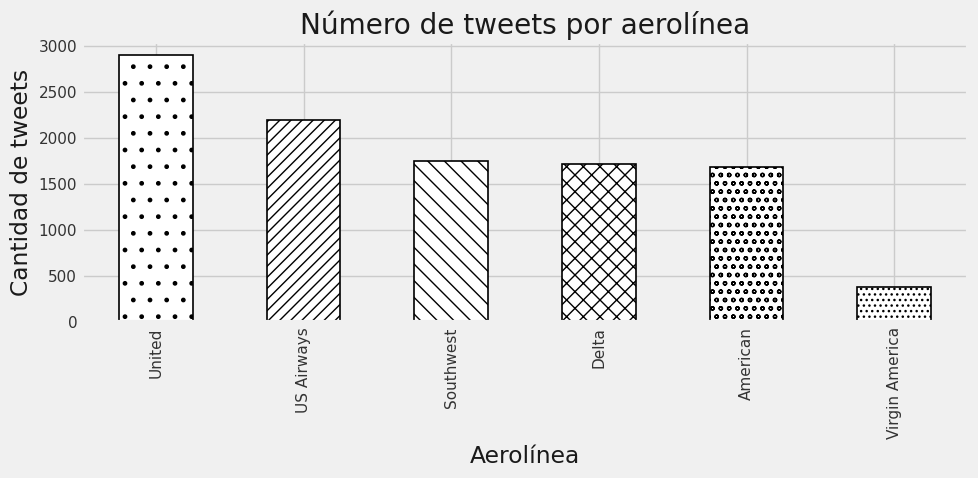

In [16]:
plt.figure(figsize=(10,5))

ax = (df_train['airline']
      .value_counts()
      .sort_values(ascending=False)
      .plot(kind='bar', color='white', edgecolor='black'))

# aplicamos patrón a cada barra
patterns = ['.', '///', '\\\\', 'xx', 'oo', '...']
bars = ax.patches

for bar, pattern in zip(bars, patterns * (len(bars)//len(patterns) + 1)):
    bar.set_hatch(pattern)
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)

plt.title("Número de tweets por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Cantidad de tweets")
plt.tight_layout()
plt.show()

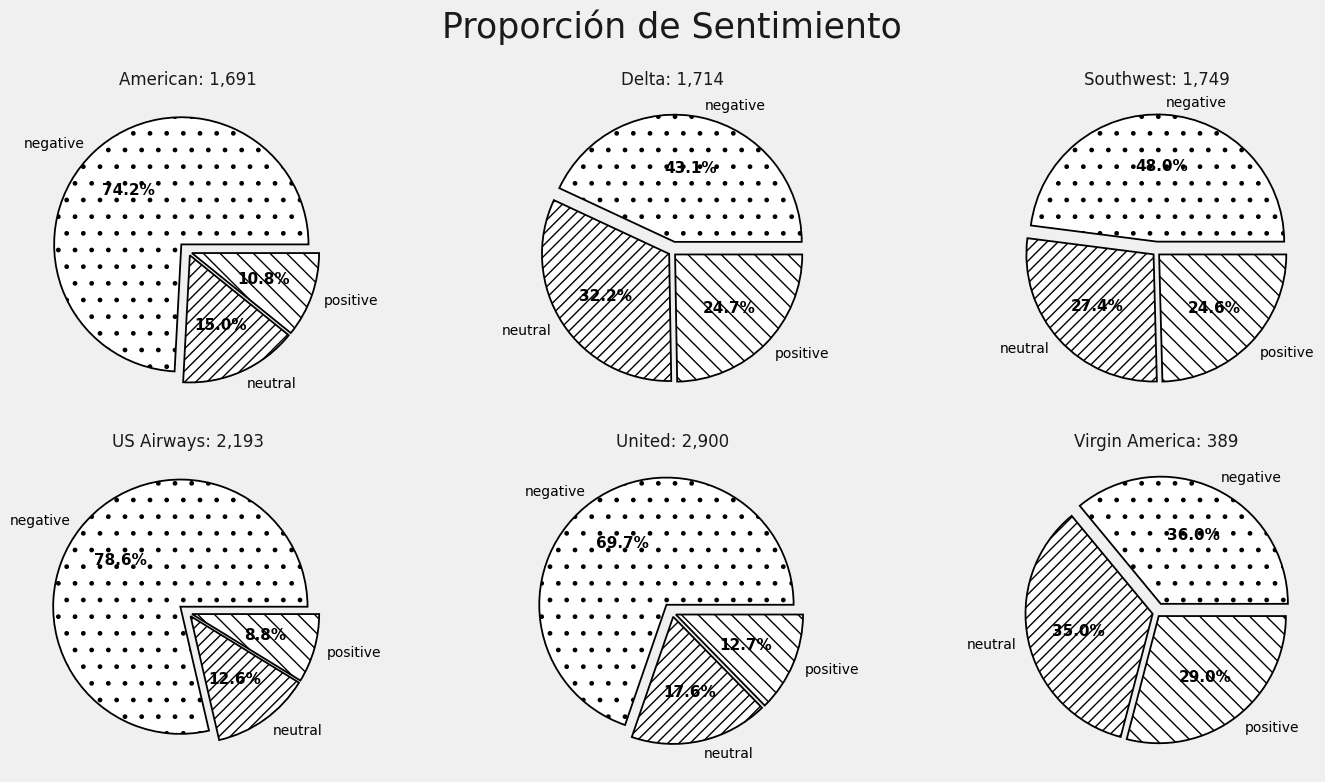

In [17]:
# Gráfica de Pie
a = df_train.groupby("airline")["label"].value_counts().unstack(fill_value=0)

# Patrones para cada slice
patterns = ['.', '///', '\\\\', 'xx', 'oo', '...']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, ax in zip(range(len(a)), axes):
    temp = a.iloc[i]

    wedges, texts, autotexts = ax.pie(
        x=temp,
        labels=temp.index,
        autopct='%1.1f%%',
        explode=[0.08, 0.03, 0.03],
        colors=["white"] * len(temp),
        textprops={'color': 'black', 'fontsize': 10}
    )


    for wedge, pattern in zip(wedges, patterns):
        wedge.set_facecolor("white")
        wedge.set_hatch(pattern)
        wedge.set_edgecolor("black")
        wedge.set_linewidth(1.3)


    for autotext in autotexts:
        autotext.set_color("black")
        autotext.set_fontsize(11)
        autotext.set_fontweight("bold")


    for text in texts:
        text.set_color("black")
        text.set_fontsize(10)

    ax.set_title(f"{a.index[i]}: {format(a.values[i].sum(), ',')}", fontsize=12)

plt.suptitle("Proporción de Sentimiento", fontsize=25)
plt.tight_layout()
plt.show()

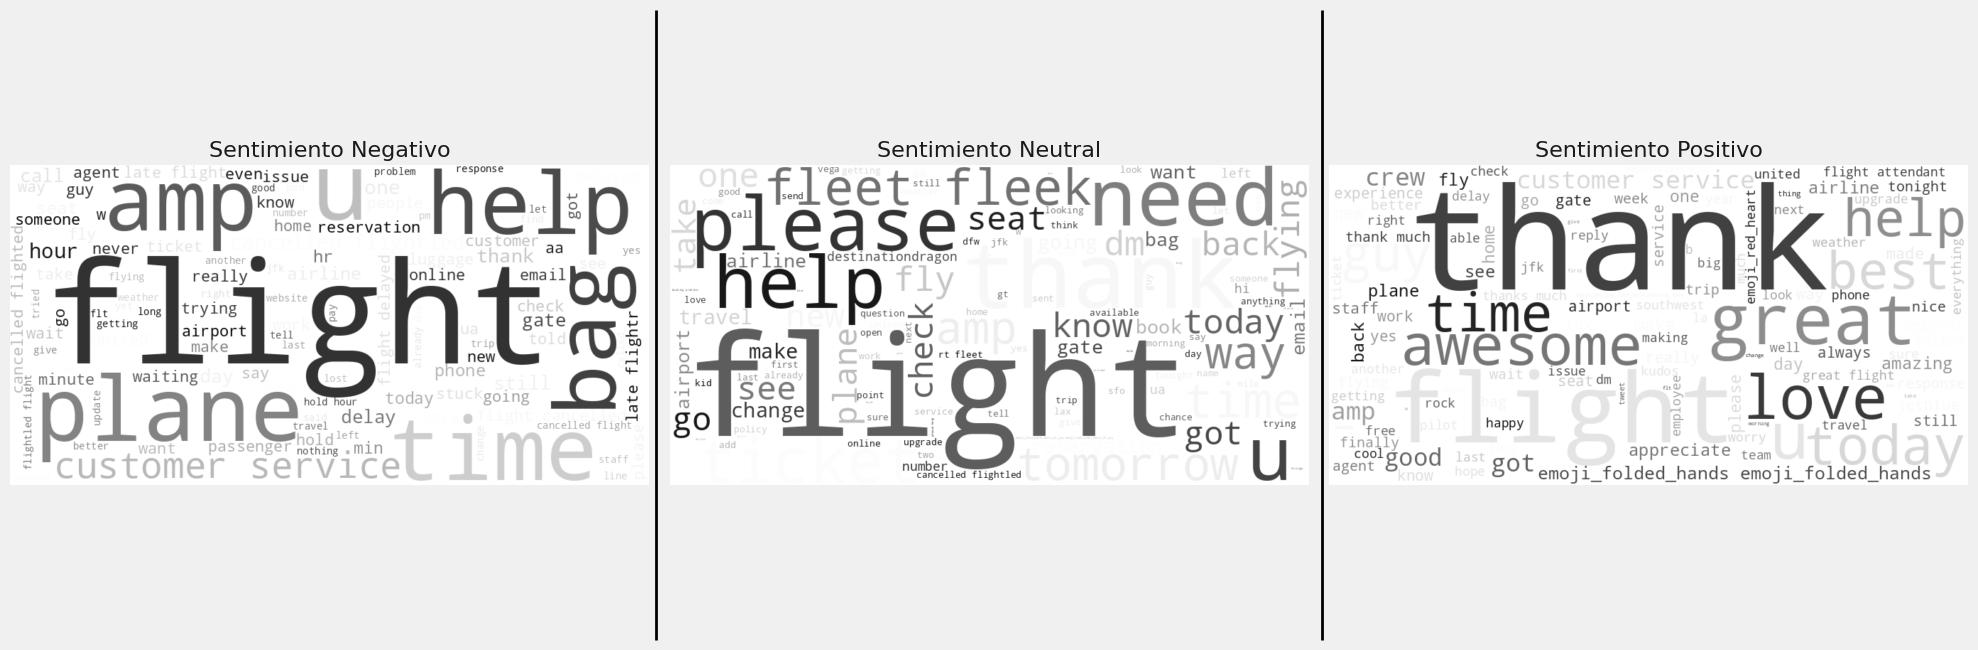

In [18]:
# Word Cloud por sentimiento
text_neg = " ".join(df_train[df_train['label'] == 'negative']['text'].astype(str).tolist())
text_neu = " ".join(df_train[df_train['label'] == 'neutral']['text'].astype(str).tolist())
text_pos = " ".join(df_train[df_train['label'] == 'positive']['text'].astype(str).tolist())

wc_neg = create_wc(text_neg)
wc_neu = create_wc(text_neu)
wc_pos = create_wc(text_pos)


fig, axes = plt.subplots(1, 3, figsize=(20, 7))


axes[0].imshow(wc_neg, interpolation='bilinear')
axes[1].imshow(wc_neu, interpolation='bilinear')
axes[2].imshow(wc_pos, interpolation='bilinear')

# Títulos
axes[0].set_title("Sentimiento Negativo", fontsize=16)
axes[1].set_title("Sentimiento Neutral", fontsize=16)
axes[2].set_title("Sentimiento Positivo", fontsize=16)


for ax in axes:
    ax.axis("off")


fig.lines.append(
    plt.Line2D(
        [1/3, 1/3],   # posición x
        [0.05, 0.95], # alto
        transform=fig.transFigure,
        color="black",
        linewidth=2
    )
)


fig.lines.append(
    plt.Line2D(
        [2/3, 2/3],
        [0.05, 0.95],
        transform=fig.transFigure,
        color="black",
        linewidth=2
    )
)

plt.tight_layout()
plt.show()

In [19]:
# Agrupamos por fecha, aerolínea y sentimiento
grouped = (
    df_train
    .groupby(['date', 'airline', 'label'])
    .size()
    .reset_index(name='count')
)

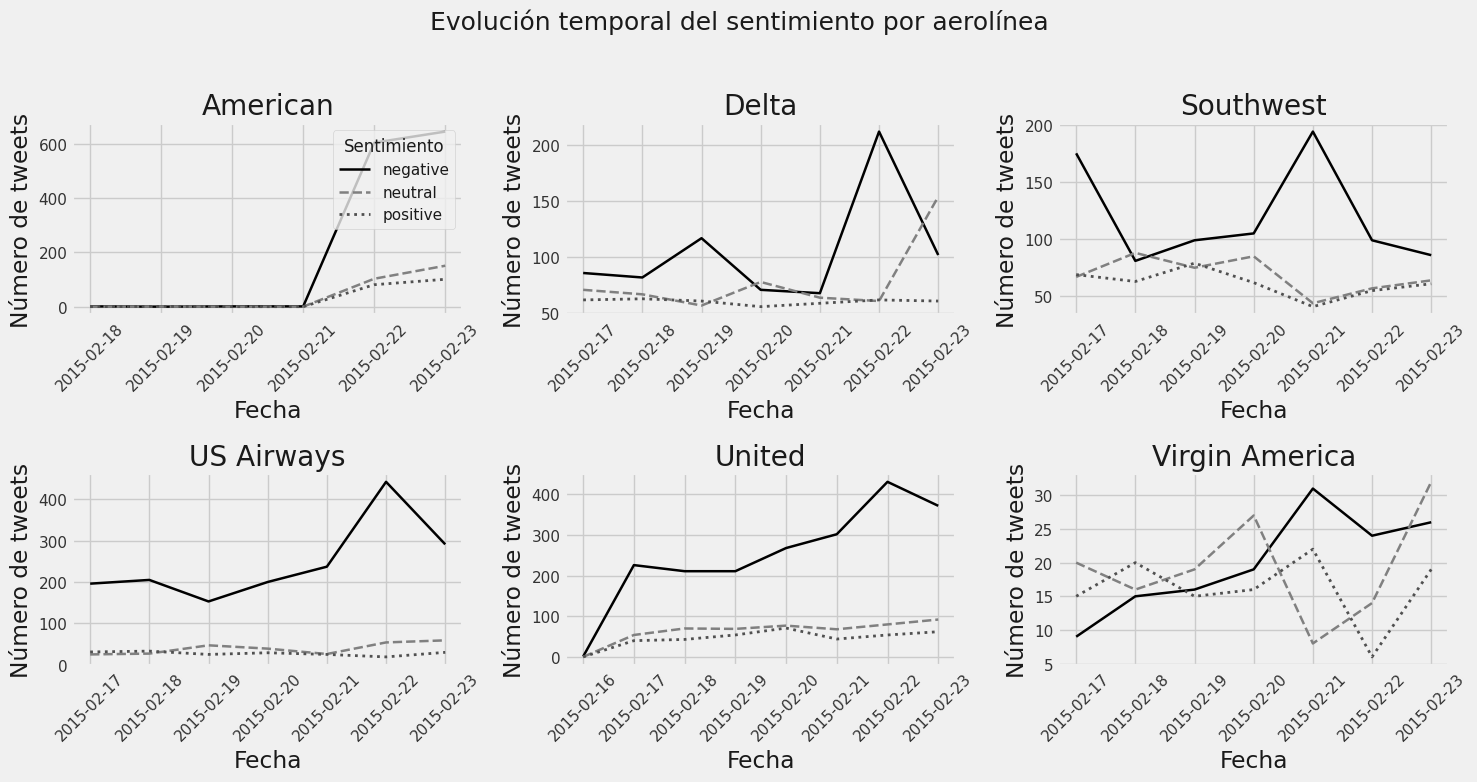

In [20]:
# Serie de tiempo del sentmiento de las aerolíneas
labels_order = ['negative', 'neutral', 'positive']

airlines = sorted(df_train['airline'].unique())
n_airlines = len(airlines)

ncols = 3
nrows = int(np.ceil(n_airlines / ncols))

plt.figure(figsize=(5*ncols, 4*nrows))

for i, airline in enumerate(airlines, start=1):
    ax = plt.subplot(nrows, ncols, i)


    temp = grouped[grouped['airline'] == airline]


    temp_pivot = (
        temp
        .pivot(index='date', columns='label', values='count')
        .reindex(columns=labels_order)   # orden fijo
        .fillna(0)
    )


    if 'negative' in temp_pivot.columns:
        ax.plot(
            temp_pivot.index,
            temp_pivot['negative'],
            label='negative',
            color='black',
            linestyle='-',
            linewidth=1.8
        )
    if 'neutral' in temp_pivot.columns:
        ax.plot(
            temp_pivot.index,
            temp_pivot['neutral'],
            label='neutral',
            color='gray',
            linestyle='--',
            linewidth=1.8
        )
    if 'positive' in temp_pivot.columns:
        ax.plot(
            temp_pivot.index,
            temp_pivot['positive'],
            label='positive',
            color='#505050',
            linestyle=':',
            linewidth=2
        )

    ax.set_title(airline)
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Número de tweets")
    ax.tick_params(axis='x', rotation=45)


    if i == 1:
        ax.legend(title="Sentimiento", loc='upper right')

plt.suptitle("Evolución temporal del sentimiento por aerolínea", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Remuestreo

In [21]:
X_trn = df_train[['text', 'negatvieason', 'airline']]
y_trn = df_train['label']

In [22]:
# X_trn

In [23]:
# Unimos X_trn y y_trn en un DataFrame
train_df = pd.DataFrame({
    'text': X_trn['text'].values,
    'negatvieason': X_trn['negatvieason'].values,
    'airline': X_trn['airline'].values,
    'label': y_trn.values
})

#  Contamos cuántos ejemplos hay por clase
counts = train_df['label'].value_counts()
max_count = counts.max()

print("Distribución original del train:")
print(counts)

#  Hacemos oversampling clase por clase
dfs_balanced = []

for label, count in counts.items():
    df_class = train_df[train_df['label'] == label]

    if count < max_count:
        df_over = df_class.sample(max_count - count, replace=True, random_state=42)
        df_class = pd.concat([df_class, df_over], axis=0)

    dfs_balanced.append(df_class)

# Unimos y mezclamos
train_df_balanced = pd.concat(dfs_balanced, axis=0).sample(frac=1, random_state=42)

print("\nDistribución balanceada:")
print(train_df_balanced['label'].value_counts())

# Extraemos tus nuevos sets balanceados
X_trn_bal = train_df_balanced[['text', 'negatvieason', 'airline']].reset_index(drop=True)
y_trn_bal = train_df_balanced['label'].reset_index(drop=True)

Distribución original del train:
label
negative    6717
neutral     2209
positive    1710
Name: count, dtype: int64

Distribución balanceada:
label
neutral     6717
negative    6717
positive    6717
Name: count, dtype: int64


# Modelación Sentimiento


## Modelos de ML

In [24]:
# usamos TfidfVectorizer para transformar los vectores de entrada al modelo
max_features = 5000
tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2,
        stop_words='english'
    )
X_tfidf = tfidf.fit_transform(X_trn_bal["text"].astype(str))
X_valid_tfidf = tfidf.transform(X_valid['final_text'].astype(str))
X_test_tfidf = tfidf.transform(X_test['final_text'].astype(str))

Fitting 3 folds for each of 7 candidates, totalling 21 fits

Mejores hiperparámetros: {'n_estimators': 200}
Mejor accuracy promedio (CV): 0.9019899756835889

Resultados por número de árboles:
n_estimators =  40 → accuracy medio = 0.9007 ± 0.0032
n_estimators =  60 → accuracy medio = 0.9010 ± 0.0030
n_estimators =  80 → accuracy medio = 0.9008 ± 0.0030
n_estimators = 100 → accuracy medio = 0.9014 ± 0.0035
n_estimators = 120 → accuracy medio = 0.9014 ± 0.0025
n_estimators = 200 → accuracy medio = 0.9020 ± 0.0031
n_estimators = 300 → accuracy medio = 0.9019 ± 0.0017


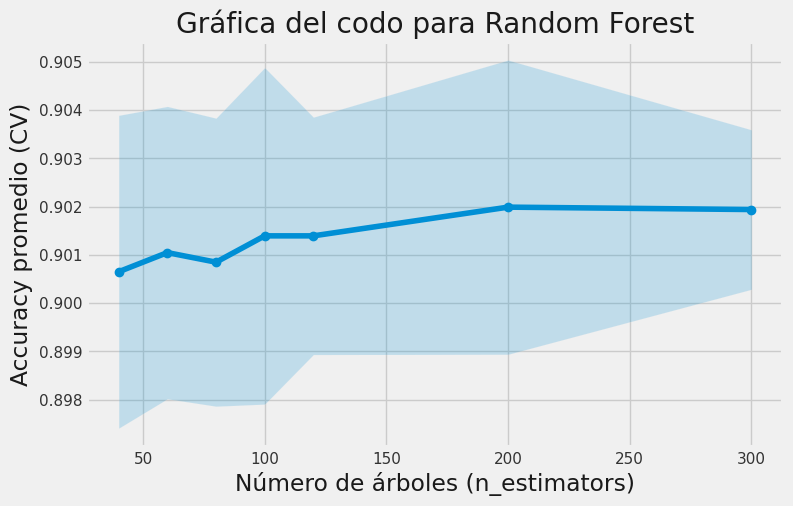

In [25]:
# CF para encontrar el mejor random forest
rf = RandomForestClassifier(
    random_state=42,
    max_depth=None
)

# Definir la malla del número de árboles
param_grid = {
    'n_estimators': [40, 60, 80, 100, 120, 200, 300]
}

# GridSearchCV con 3-fold CV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_tfidf, y_trn_bal)

print("\nMejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy promedio (CV):", grid.best_score_)

mean_scores = grid.cv_results_['mean_test_score']
std_scores  = grid.cv_results_['std_test_score']
n_estimators_list = param_grid['n_estimators']

print("\nResultados por número de árboles:")
for n, m, s in zip(n_estimators_list, mean_scores, std_scores):
    print(f"n_estimators = {n:3d} → accuracy medio = {m:.4f} ± {s:.4f}")

#  Gráfica del codo
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, mean_scores, marker='o')
plt.fill_between(
    n_estimators_list,
    mean_scores - std_scores,
    mean_scores + std_scores,
    alpha=0.2
)
plt.xlabel("Número de árboles (n_estimators)")
plt.ylabel("Accuracy promedio (CV)")
plt.title("Gráfica del codo para Random Forest")
plt.grid(True)
plt.show()

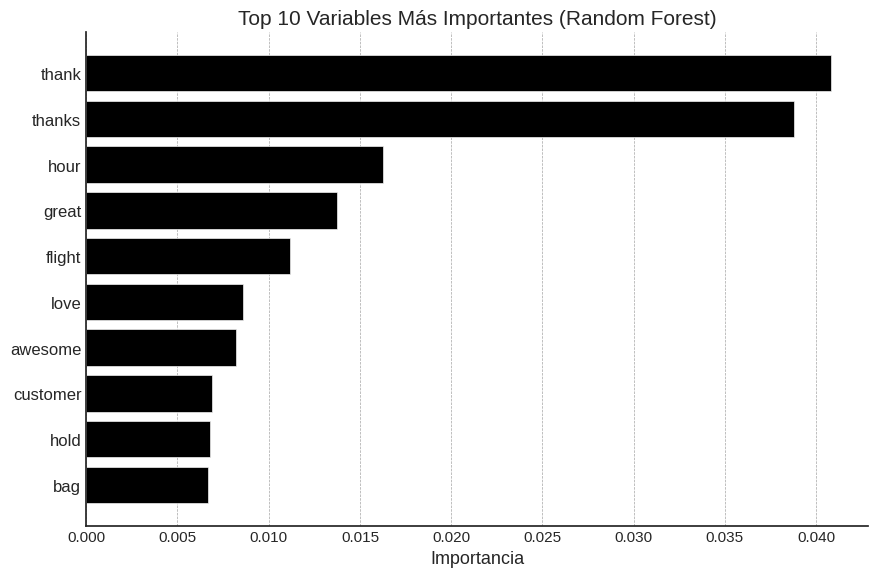

In [26]:
# Vemos las variables más importantes

best_rf = grid.best_estimator_

feature_importances = best_rf.feature_importances_
feature_names = np.array(tfidf.get_feature_names_out())

# ordenar de mayor a menor
indices = np.argsort(feature_importances)[::-1]
top_n = 10

top_features = feature_names[indices[:top_n]]
top_values   = feature_importances[indices[:top_n]]

plt.style.use('seaborn-v0_8-white')

fig, ax = plt.subplots(figsize=(9, 6))


ax.barh(
    y=np.arange(top_n),
    width=top_values[::-1],
    color='black'
)


ax.set_yticks(np.arange(top_n))
ax.set_yticklabels(top_features[::-1], fontsize=12)


ax.set_xlabel("Importancia", fontsize=13)
ax.set_title("Top 10 Variables Más Importantes (Random Forest)", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

In [27]:
# --- Métricas del RF ---
print("\n--- RANDOM FOREST ---")
y_pred_rf = best_rf.predict(X_valid_tfidf)
print(classification_report(y_valid, y_pred_rf))
print(confusion_matrix(y_valid, y_pred_rf))


--- RANDOM FOREST ---
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      1680
     neutral       0.54      0.56      0.55       553
    positive       0.64      0.63      0.63       427

    accuracy                           0.75      2660
   macro avg       0.68      0.68      0.68      2660
weighted avg       0.75      0.75      0.75      2660

[[1407  197   76]
 [ 169  310   74]
 [  93   66  268]]


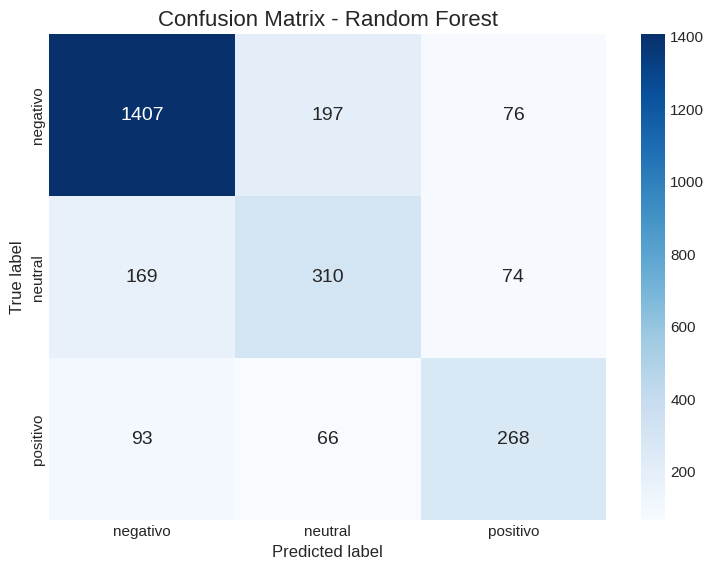

In [29]:
# Mtriz de confución del RF
y_pred = best_rf.predict(X_valid_tfidf)

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred)


class_names = ["negativo", "neutral", "positivo"]

plt.figure(figsize=(8,6))
sns.heatmap(
cm,
cmap=plt.cm.Blues,
annot=True,
fmt='d',
xticklabels=class_names,
yticklabels=class_names
)

plt.title('Confusion Matrix - Random Forest', fontsize=16)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

## LSTM

In [30]:
# Aplicamos la tokenización y el padding
y_trn = pd.get_dummies(y_trn_bal)
X_trn, tokenizer = tokenize_pad_sequences(X_trn_bal['text'])
y_vld = pd.get_dummies(y_valid)
X_vld = tokenize_valid_set(X_valid['final_text'], tokenizer)
y_tst = pd.get_dummies(y_test)
X_tst = tokenize_valid_set(X_test['final_text'], tokenizer)

In [31]:
# Tamaño de los Sets de Datos
print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Validation Set:', X_tst.shape, y_tst.shape)

Train:          (20151, 50) (20151, 3)
Validation Set: (2660, 50) (2660, 3)
Validation Set: (1344, 50) (1344, 3)


In [32]:
# extraemos las palabras de cada tweet siempre y cuándo esten en el diccionario que hemos creado con tokenizer
word_index = tokenizer.word_index
index_word = {i: w for w, i in word_index.items()}

sentences = []
for seq in X_trn:
    # quitamos los ceros (padding)
    words = [index_word[idx] for idx in seq if idx != 0 and idx in index_word]
    if words:
        sentences.append(words)

In [33]:
# DEfine los parámetros del embedding
embedding_dim = 100  #

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=embedding_dim,
    window=5,
    min_count=1,
    sg=1
)

In [34]:
# Asigna los embeddings
vocab_size = 10000
num_words = min(vocab_size, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    # si no está, se queda el vector 0

In [35]:
# Definimos que sólo utilizaremos las 10000 palabras más mencionadas
vocab_size = 10000
# Definimosel tamaño del ambedding
embedding_size = 100

# Definimos la arquitectura de la Red
model = Sequential()
model.add(
    Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True   # Este parámetro le permite a la matriz de embeddings actualizarse
    )
)

model.add(Bidirectional(LSTM(32)))

model.add(Dense(3, activation='softmax'))

model.build(input_shape=(None, max_len))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


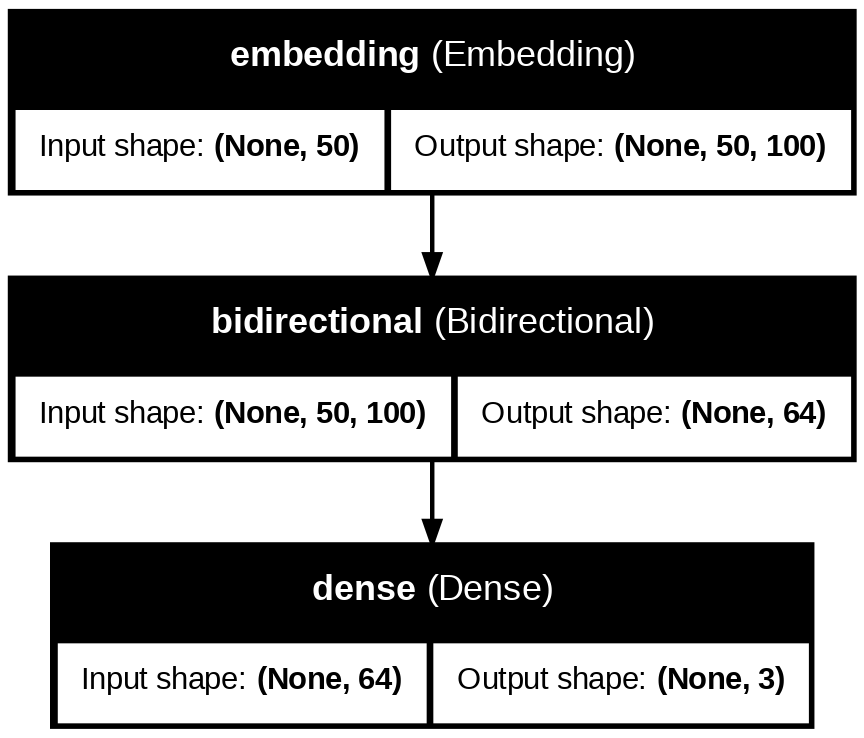

In [36]:
# Visualización del Modelo
plot_model(
    model,
    to_file='modelo_lstm.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=160,
    expand_nested=False
)

In [37]:
# Definimos el Early Stopping
es = EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights=True)
batch_size = 64
epochs = 30

# Entrenamos el modelo
history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [es])

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.6750 - loss: 0.7639 - val_accuracy: 0.7481 - val_loss: 0.5967
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.8641 - loss: 0.3649 - val_accuracy: 0.7628 - val_loss: 0.6367
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9288 - loss: 0.2073 - val_accuracy: 0.7665 - val_loss: 0.7340
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9560 - loss: 0.1347 - val_accuracy: 0.7526 - val_loss: 0.8839


### Métricas

In [38]:
# Métricas del modelo RF
y_pred_probs = model.predict(X_vld)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convertir y_vld one-hot a etiquetas
y_true = np.argmax(y_vld.values, axis=1)

# ----------- Accuracy -----------
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy en validación: {accuracy:.4f}")

# ----------- Reporte de clasificación -----------
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['negativo','neutral','positivo']))

# ----------- Matriz de confusión -----------
print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy en validación: 0.7481

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       0.90      0.77      0.83      1680
     neutral       0.51      0.72      0.60       553
    positivo       0.66      0.69      0.67       427

    accuracy                           0.75      2660
   macro avg       0.69      0.73      0.70      2660
weighted avg       0.78      0.75      0.76      2660

Matriz de confusión:
[[1299  295   86]
 [  91  397   65]
 [  52   81  294]]


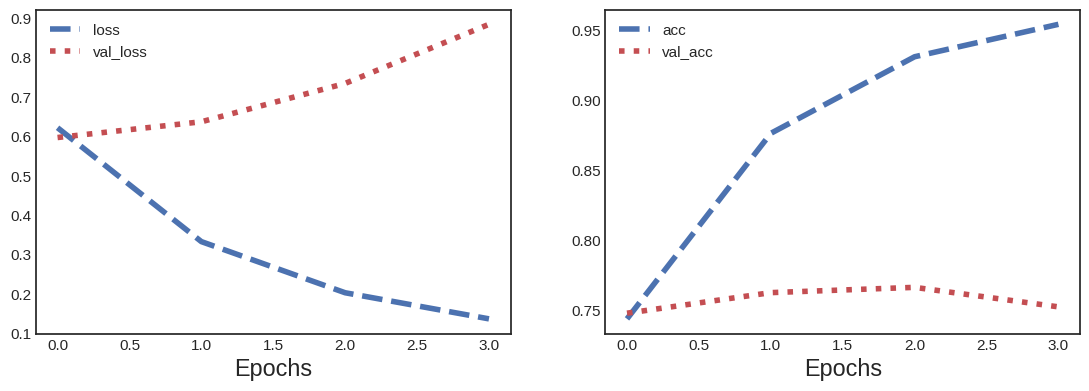

In [39]:
# Curvas de aprendizaje modelo recurrente
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


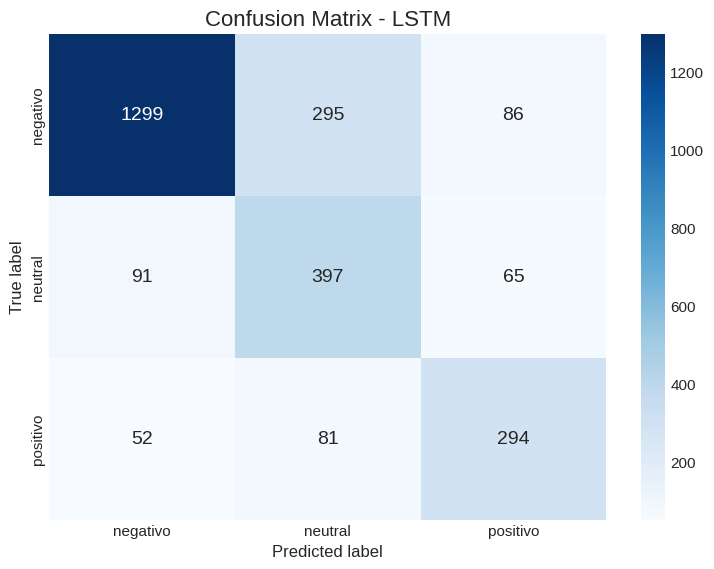

In [40]:
# confusion matriz LSTM
plot_confusion_matrix(model, X_vld, y_vld)


# Evaluación en Datos nunca vistos

## LSTM

In [41]:
y_pred_probs = model.predict(X_tst)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convertir y_vld one-hot a etiquetas
y_true = np.argmax(y_tst.values, axis=1)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [42]:
df_noseendata_lstm = X_test.copy()
df_noseendata_lstm['true_sentimen'] = y_true
df_noseendata_lstm['pred_sentiment'] = y_pred

In [79]:
x_test_sin_pred = X_test.reset_index(drop =True)
x_test_w_pred = df_noseendata_lstm.reset_index(drop =True)[['true_sentimen', 'pred_sentiment']]

In [81]:
# muestra de como predice el modelo
x_test_sin_pred.join(x_test_w_pred)[['text', 'true_sentimen', 'pred_sentiment']]

,text,true_sentimen,pred_sentiment
0,@VirginAmerica What @dhepburn said.,1,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,2,1
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,1,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0,0
4,@VirginAmerica and it's a really big bad thing about it,0,2
...,...,...,...
1339,@AmericanAir WORST SERVICE EVER!! Delayed flights for more than 5 hours plus you missed my bag! And your employees are rude 😡😡,0,0
1340,@AmericanAir thanks for the generic computer generated response. How about you accommodate your travelers instead of just saying sorry,0,0
1341,@AmericanAir they are giving cots to the people that did not get hotel rooms...that is terrible..,0,0
1342,"@AmericanAir I did twice.got a letter back saying that your company ""doesn't issue refunds for phone bills"" help!phone will be shut off",0,0


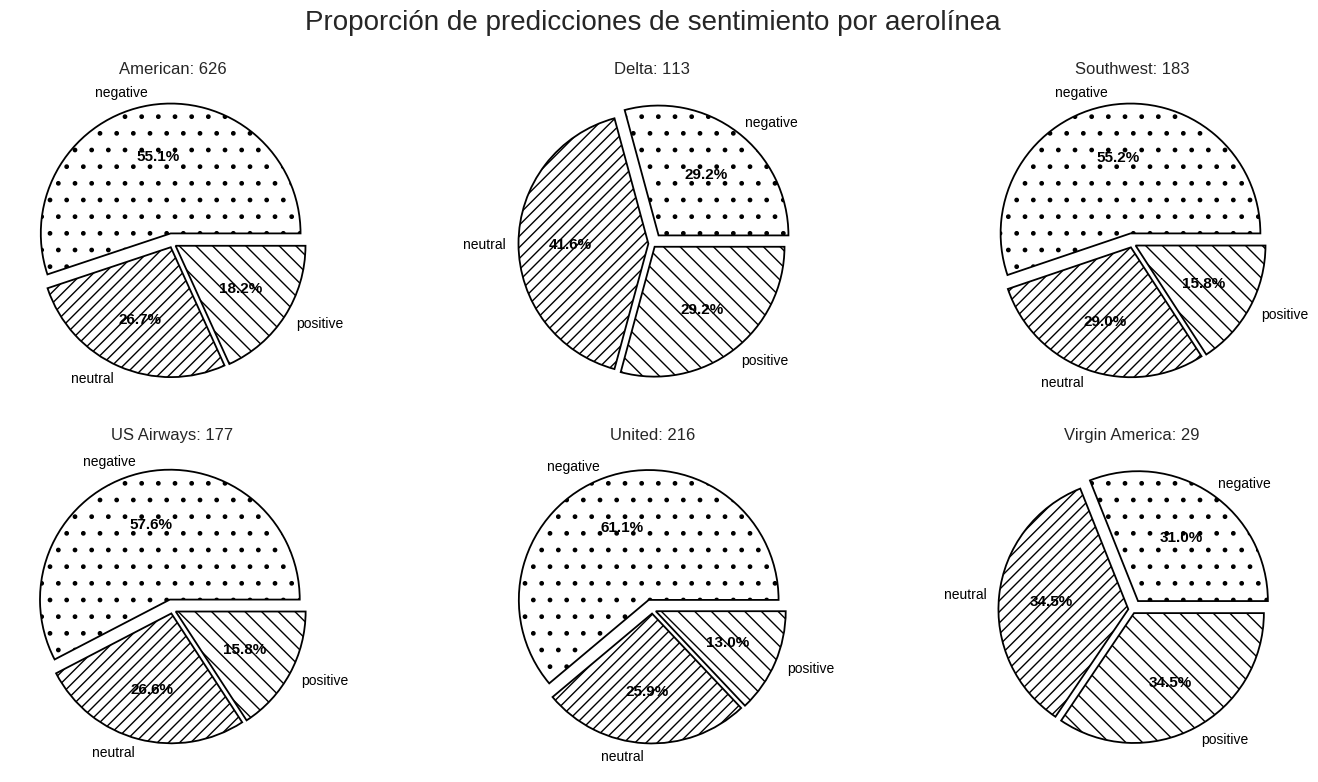

In [44]:
a = (
    df_noseendata_lstm
    .groupby("airline")["pred_sentiment"]
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=[0, 1, 2], fill_value=0)
)

#  Patrones para cada slice (una por sentimiento)
patterns = ['.', '///', '\\\\']  # 0: neg, 1: neu, 2: pos

#  Etiquetas de las clases (para el pie)
sentiment_labels = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

#  Crear subplots
n_airlines = len(a)
n_rows = 2
n_cols = 3  # asumiendo 6 aerolíneas; ajusta si son más/menos

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for i, ax in zip(range(n_airlines), axes):
    temp = a.iloc[i]

    # etiquetas de texto según el índice
    labels = [sentiment_labels[idx] for idx in temp.index]

    wedges, texts, autotexts = ax.pie(
        x=temp.values,
        labels=labels,
        autopct='%1.1f%%',
        explode=[0.08, 0.03, 0.03],
        colors=["white"] * len(temp),  # fondo blanco
        textprops={'color': 'black', 'fontsize': 10}
    )

    # aplicar patrones
    for wedge, pattern in zip(wedges, patterns):
        wedge.set_facecolor("white")
        wedge.set_hatch(pattern)
        wedge.set_edgecolor("black")
        wedge.set_linewidth(1.3)

    # mejorar porcentajes
    for autotext in autotexts:
        autotext.set_color("black")
        autotext.set_fontsize(11)
        autotext.set_fontweight("bold")

    # mejorar labels
    for text in texts:
        text.set_color("black")
        text.set_fontsize(10)

    # título de cada subplot: nombre de aerolínea + total de ejemplos
    ax.set_title(f"{a.index[i]}: {temp.sum():,}", fontsize=12)

for j in range(n_airlines, len(axes)):
    axes[j].axis('off')

plt.suptitle("Proporción de predicciones de sentimiento por aerolínea", fontsize=20)
plt.tight_layout()
plt.show()